In [1]:
import pickle
import numpy
import pandas as pd
import sys

sys.path.append('src/')

from dataset_reader import read_data

from helpers import jaccard,to_set

from IPython.display import display
%matplotlib inline
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] =(20,10)
pd.options.display.max_rows = 2000
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['text.usetex' ] = True

plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 36
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['font.size'] = 36
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18

## Helper functions

In [2]:
# computes total variation distance

def statistical_distance(n, l):
    if n == 0:
        return 0
    return sum([abs(x/sum(l) - 1/n) for x in l]) * 0.5
    
def entropy(l):
    ll = list(l)
    norm = sum(l)
    for i in range(len(ll)):
        ll[i] /= norm
    res = 0
    for i in range(len(ll)):
        res += ll[i] * math.log(ll[i])
    return -res
    

In [3]:
def compute_distribution(df, ground_truth, min_dist=0.3):
    queries = set(ground_truth[0])
    l = []
    neighbor_cnt = []
    for q in queries:
        cnts = [x[0] for x in df[df.query_id == q][['similarity']].values]
        n_neighbors = len([x for x in ground_truth[1][q] if x >= min_dist]) - 1 # -1 cause query itself is included
        neighbor_cnt.append(n_neighbors)
        l.append(statistical_distance(n_neighbors, cnts))
    return l, neighbor_cnt, entropy(cnts)

In [4]:
def get_distribution(df, ground_truth, sim):
    res = {}
    for m in sorted(set(df.method.values)):
        ddf = df[(df.r == sim) & (df.method == m)][['query_id', 'neighbor_id', 'similarity']].groupby(['query_id', 'neighbor_id']).count().reset_index()
        dist, neighbors, entropy = compute_distribution(ddf, ground_truth, sim)
        res[m] = (numpy.mean(dist), numpy.std(dist), numpy.mean(neighbors), numpy.std(neighbors), entropy)

    return res

In [5]:
def remote_edge(S):
    if len(S) <= 1:
        return 0
    SS = []
    for x in S:
        for y in S:
            if x != y:
                SS.append((x,y))
    return min([jaccard(x, y) for x,y in SS])

def remote_clique(S):
    if len(S) <= 1:
        return 0
    SS = []
    for x in S:
        for y in S:
            if x != y:
                SS.append((x,y))
    return sum([jaccard(x, y) for x,y in SS])

In [6]:
def get_top_neighbors(df, sim, k):
    dist_df = df[df.r == sim][['query_id', 'neighbor_id', 'similarity']].groupby(['query_id', 'neighbor_id']).count().reset_index()
    dist_df = dist_df.sort_values(['query_id', 'similarity']).groupby('query_id').tail(k)
    return dist_df[['query_id', 'neighbor_id']].values

# Evaluation

In [7]:
# load dataset, load ground truth

def load_data(name, csvname):
    df = pd.read_csv(csvname)
    df = df.mask(df.eq('None')).dropna() 
    df['neighbor_id'] = df['neighbor_id'].astype(int)
    dataset = to_set(read_data(name + '.dat'))

    with open(name + '.dat.pickle', 'rb') as f:
        ground_truth = pickle.load(f)
        
    df['similarity'] = df[['query_id', 'neighbor_id']].apply(lambda x: jaccard(dataset[int(x[0])], dataset[int(x[1])]), axis=1)
        
    return dataset, df, ground_truth

## b_cr / b_r term

Exact variants needs additional running time polylog(n) *  b(q, cr) / b(q, r). We investigate here the effect of this term in relation to n^rho.

In [8]:
lastfm_dataset, lastfm_df, lastfm_ground_truth = load_data('lastfm', 'results_lastfm.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/usr/local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


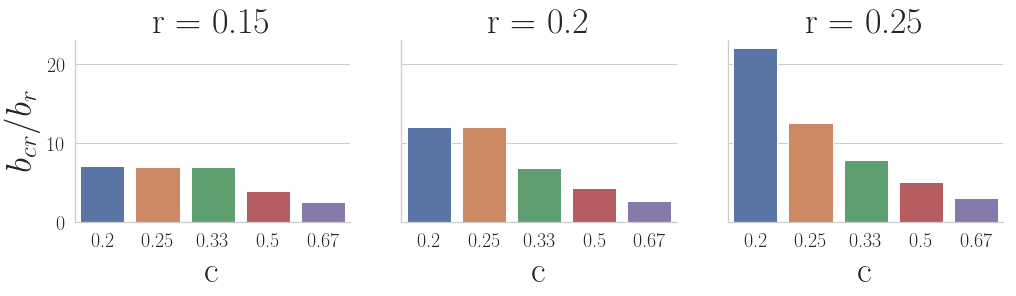

In [9]:
plt.rcParams['axes.labelsize'] = 36
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['font.size'] = 36
rs = set(lastfm_df.r.values)

ball_df = pd.DataFrame(data={'r' : [], 'c' : [], 'br' : [], 'bcr' :[], 'i' : [] })

for r in rs:
    for c in (2/3, 1/2, 1/3, 1/4, 1/5):
        for i in range(len(lastfm_ground_truth[1])):
            b_r = len([1 for i in lastfm_ground_truth[1][i] if i >= r])
            b_cr = len([1 for i in lastfm_ground_truth[1][i] if i >= r * c])
            ball_df = ball_df.append({'r': r, 'c' : c, 'br': b_r, 'bcr' : b_cr, 'i' : i}, ignore_index=True)
            
            
ball_grouped_df = ball_df[ball_df.r <= 0.25].groupby(['r', 'c']).sum().reset_index()
ball_grouped_df['rel'] = ball_grouped_df[['br', 'bcr']].apply(lambda x: x[1] / x[0], axis=1)
sns.catplot(data=ball_grouped_df[['r', 'c', 'rel']].round(2).rename(columns={'rel' : '$b_{cr} / b_r$'}),x='c', y='$b_{cr} / b_r$', kind='bar', col='r')
#plt.savefig('fraction_lastfm.pdf')

In [10]:
movielens_dataset, movielens_df, movielens_ground_truth = load_data('movielens', 'results_movielens.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/usr/local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


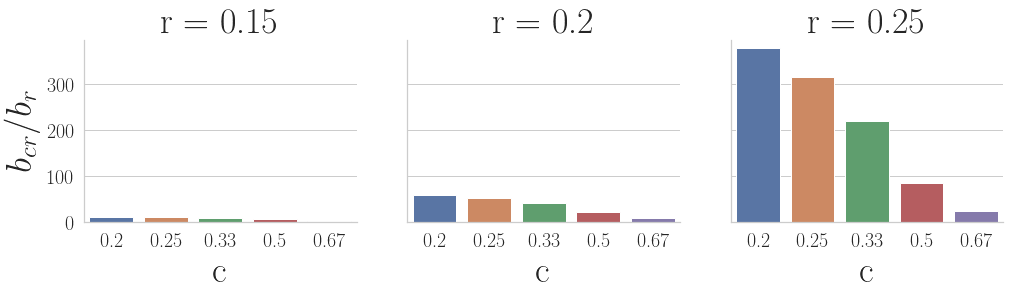

In [11]:
rs = set(movielens_df.r.values)

ball_df = pd.DataFrame(data={'r' : [], 'c' : [], 'br' : [], 'bcr' :[], 'i' : [] })

for r in rs:
    for c in (2/3, 1/2, 1/3, 1/4, 1/5):
        for i in range(len(movielens_ground_truth[1])):
            b_r = len([1 for i in movielens_ground_truth[1][i] if i >= r])
            b_cr = len([1 for i in movielens_ground_truth[1][i] if i >= c*r])
            ball_df = ball_df.append({'r': r, 'c' : c, 'br': b_r, 'bcr' : b_cr, 'i' : i}, ignore_index=True)
            
ball_grouped_df = ball_df.groupby(['r', 'c']).sum().reset_index()
ball_grouped_df['rel'] = ball_grouped_df[['br', 'bcr']].apply(lambda x: x[1] / x[0], axis=1)
sns.catplot(data=ball_grouped_df[['r', 'c', 'rel']].round(2).rename(columns={'rel' : '$b_{cr} / b_r$'}),x='c', y='$b_{cr} / b_r$', kind='bar', col='r')
#plt.savefig('fraction_movielens.pdf')

## Query times

In [12]:
# check for running time differences

lastfm_df[['method', 'query_time', 'r', 'L']].groupby(['method', 'r', 'L']).mean()

query_time
method   r    L               
standard 0.15 1164    0.033035
         0.20 760     0.023707
         0.25 505     0.014819
         0.30 340     0.009352
uniform  0.15 1164    0.038917
         0.20 760     0.028647
         0.25 505     0.018566
         0.30 340     0.012021

In [13]:
movielens_df[['method', 'query_time', 'r', 'L']].groupby(['method', 'r', 'L']).mean()

query_time
method   r    L               
standard 0.15 2025    0.200626
         0.20 1268    0.139884
         0.25 808     0.102699
uniform  0.15 2025    0.230573
         0.20 1268    0.168251
         0.25 808     0.126615

## Distribution of output points

### Difference to Uniform Distribution

In [14]:
def difference_to_uniform(df, ground_truth):
    distribution_df = pd.DataFrame(data={'r' : [], 'entropy': [], 'method': [], 'mean' : [], 'std' : [], 'neighbors mean' : [], 'neighbors std': []})


    for sim in set(df.r.values):
        res = get_distribution(df, ground_truth, sim)
        for m in res:
            distribution_df = distribution_df.append({'r' : sim, 'method' : m, 'mean' : res[m][0], 'std' : res[m][1], 'neighbors mean' : res[m][2], 'neighbors std': res[m][3], 'entropy' : res[m][4]}, ignore_index=True)

    return distribution_df

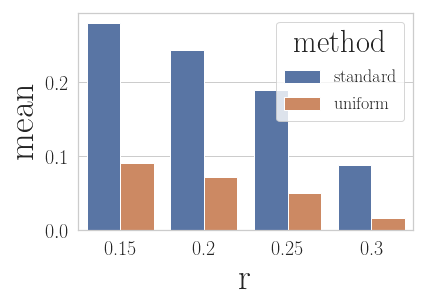

In [15]:
sns.barplot(data=difference_to_uniform(lastfm_df, lastfm_ground_truth), x='r', y='mean', hue='method')

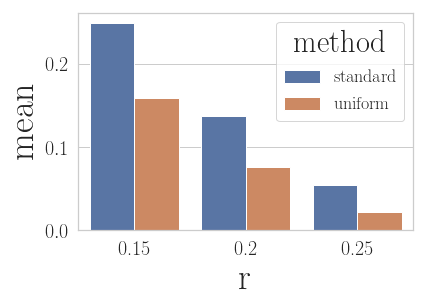

In [16]:
sns.barplot(data=difference_to_uniform(movielens_df, movielens_ground_truth), x='r', y='mean', hue='method')

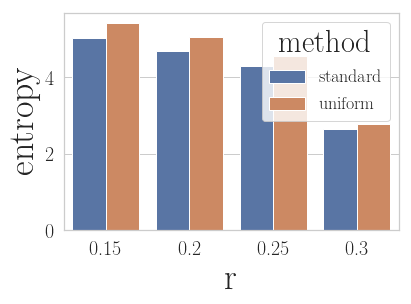

In [17]:
sns.barplot(data=difference_to_uniform(lastfm_df, lastfm_ground_truth), x='r', y='entropy', hue='method')

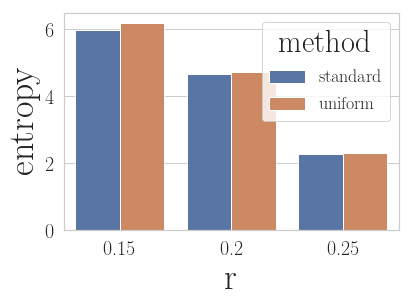

In [18]:
sns.barplot(data=difference_to_uniform(movielens_df, movielens_ground_truth), x='r', y='entropy', hue='method')

Consequently, uniform selection increases entropy.

### Aggregate Diversity, Remote Clique (sum of distances between neighbors), Remote Edge (closest pair of neighbors)

In [19]:
# compute aggregate diversity

def compute_cost(f, label, df, div_df, dataset):
    for sim in set(df.r.values):
        for K in [5, 10, 20, 50]:
            for m in sorted(set(df.method.values)):
                dd = {}
                res = []
                for k, v in get_top_neighbors(df[df.method == m], sim, K):
                    dd.setdefault(k, []).append(v)
                for k in dd:
                    res.append(f([dataset[x] for x in dd[k]]))
                div_df = div_df.append({'measure' : label, 
                                'method' : m, 
                                'sim' : sim, 
                                'k' : K, 
                                'div' : numpy.mean(res)}, ignore_index=True)
                
    return div_df

def compute_diversity_measures(df, dataset):

    div_df = pd.DataFrame(data = {'measure' : [], 'method' : [], 'sim' : [], 'k' : [], 'div' : []})

    for sim in set(df.r.values):
        for k in [5, 10, 20, 50]:
            for m in sorted(set(df.method.values)):
                div_df = div_df.append({'measure': 'aggregate-diversity', 'method' : m, 'sim' : sim, 'k' : k, 'div' : 
                        len(set([x[1] for x in get_top_neighbors(df[df.method == m], 
                            sim, k)]))}, ignore_index=True)
    div_df = compute_cost(remote_edge, 'remote-edge', df, div_df, dataset)
    div_df = compute_cost(remote_clique, 'remote-clique', df, div_df, dataset)
    
    return div_df
            

In [20]:
div_df = compute_diversity_measures(lastfm_df, lastfm_dataset)

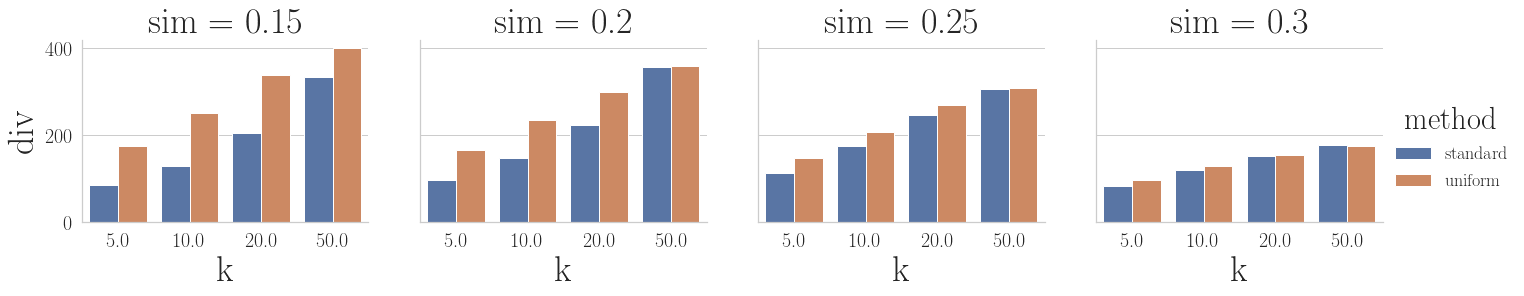

In [21]:
sns.catplot(data=div_df[div_df.measure == 'aggregate-diversity'].sort_values(['method']), hue='method', x='k', y='div', kind='bar', col='sim')

Aggregate diversity is better with uniform choice when output size is relatively large (i.e., low similarity), seems worse for small output size?

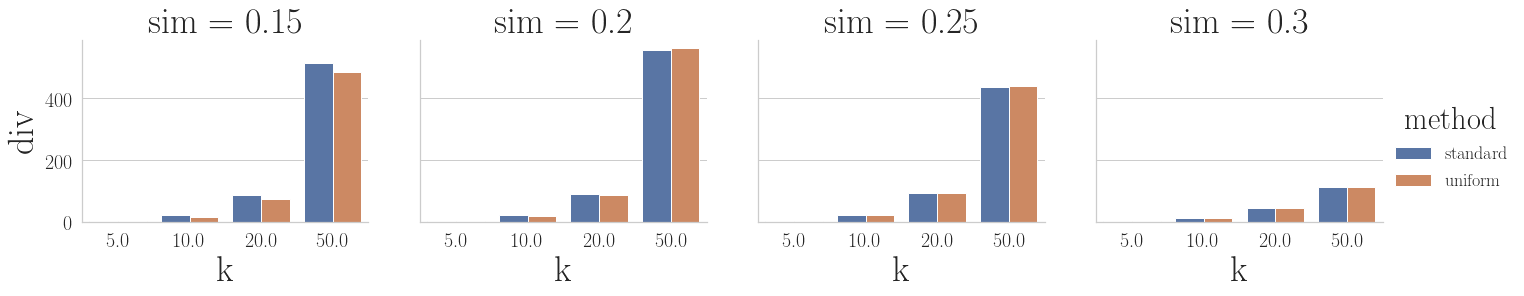

In [22]:
sns.catplot(data=div_df[div_df.measure == 'remote-clique'].sort_values(['method']), hue='method', x='k', y='div', kind='bar', col='sim')

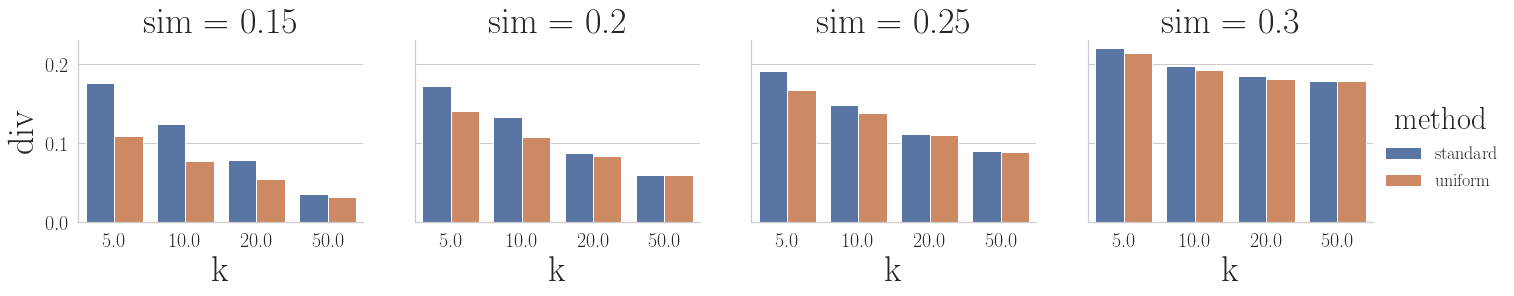

In [23]:
sns.catplot(data=div_df[div_df.measure == 'remote-edge'].sort_values(['method']), hue='method', x='k', y='div', kind='bar', col='sim')

## Fairness of output

In [24]:
def produce_distribution_plot(df, r, method,scale=1000):
    plot_df = (df[(df.method==method) & (df.r == r)])[['query_id', 'neighbor_id', 'query_time', 'similarity']].groupby(['query_id', 'neighbor_id', 'similarity']).count().reset_index() # get output counts
    plot_df = plot_df.groupby(['query_id', 'similarity']).mean().reset_index()
    # reorder query ids
    dd = {}
    i = 0
    for x in set(plot_df.query_id.values):
        dd[x] = i
        i += 1
    
    plot_df['query_id'] = plot_df['query_id'].replace(dd)
    norm = max(plot_df.groupby(['query_id']).sum().reset_index()[['query_time']].values)
    #norm = 1
    
    #plot_df = plot_df.merge(normalization_df, left_on = 'query_id', right_on = 'query_id')
    plot_df['norm_count'] = plot_df[['query_time']].apply(lambda x: x / norm)
    
    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    
    max_size = max(plot_df.norm_count.values)
    sns.scatterplot(data=plot_df.rename(
                    columns={'query_id' : 'Query', 
                             'norm_count' : 'rel freq', 
                             'similarity' : 'Similarity'}), 
                  x='Similarity', y = 'Query', 
                  hue='rel freq',
                  size='rel freq', 
                  sizes = (1, max_size * scale),
                  palette=cmap
                 )   
    leg = plt.legend()
    for t in leg.texts:
    # truncate label text to 4 characters
        t.set_text(t.get_text()[:4])
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

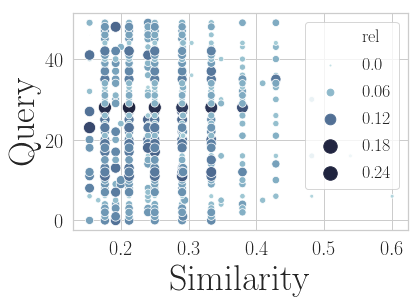

In [25]:
plt.rcParams['legend.fontsize'] = 18
produce_distribution_plot(lastfm_df, 0.15, 'uniform')
#plt.savefig('lastfm015_uniform.pdf')

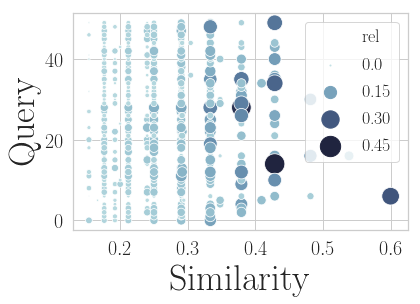

In [26]:
produce_distribution_plot(lastfm_df, 0.15, 'standard')
#plt.savefig('lastfm015_standard.pdf')

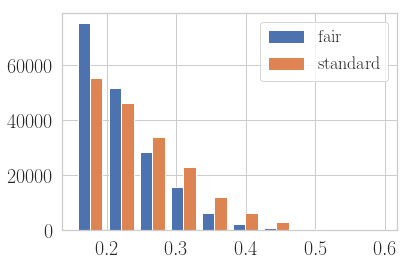

In [27]:
a = lastfm_df[(lastfm_df.r == 0.15) & (lastfm_df.method == 'uniform')][['similarity']].values
b = lastfm_df[(lastfm_df.r == 0.15) & (lastfm_df.method == 'standard')][['similarity']].values

plt.hist(x=[a.flatten(), b.flatten()])
plt.legend(['fair', 'standard'])

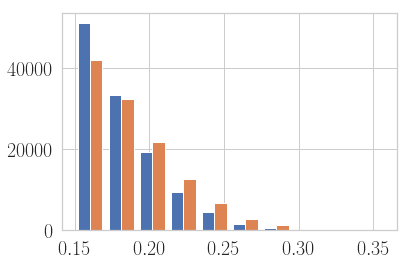

In [28]:
a = movielens_df[(movielens_df.r == 0.15) & (movielens_df.method == 'uniform')][['similarity']].values
b = movielens_df[(movielens_df.r == 0.15) & (movielens_df.method == 'standard')][['similarity']].values

ax = plt.hist(x=[a.flatten(), b.flatten()])

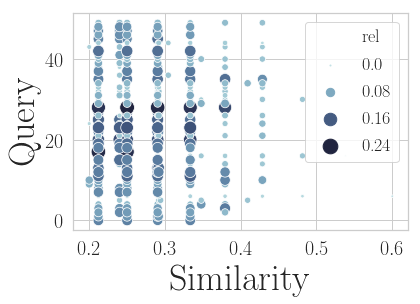

In [29]:
produce_distribution_plot(lastfm_df, 0.2, 'uniform') 

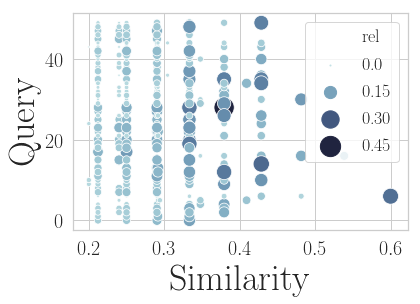

In [30]:
produce_distribution_plot(lastfm_df, 0.2, 'standard') 

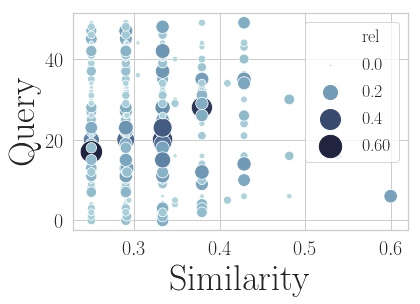

In [31]:
produce_distribution_plot(lastfm_df, 0.25, 'standard') 

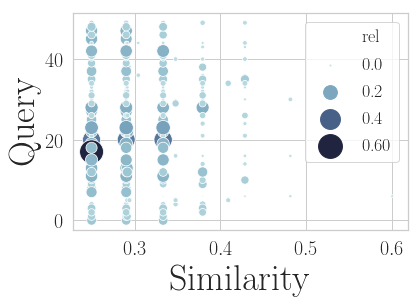

In [32]:
produce_distribution_plot(lastfm_df, 0.25, 'uniform') 

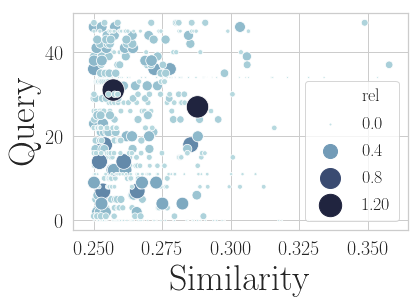

In [33]:
produce_distribution_plot(movielens_df, 0.25, 'uniform', 500) 

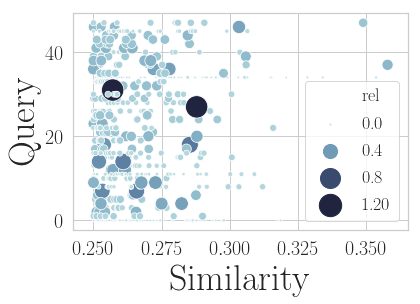

In [34]:
produce_distribution_plot(movielens_df, 0.25, 'standard', 500) 

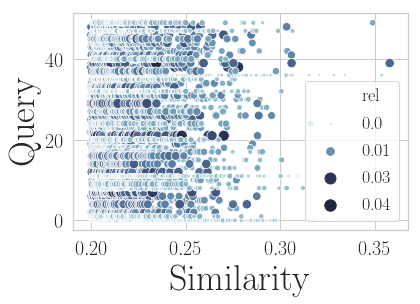

In [35]:
produce_distribution_plot(movielens_df, 0.2, 'uniform', 4000) 

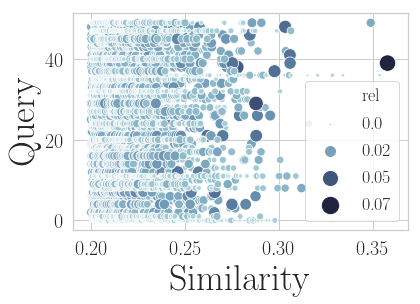

In [36]:
produce_distribution_plot(movielens_df, 0.2, 'standard', 4000) 

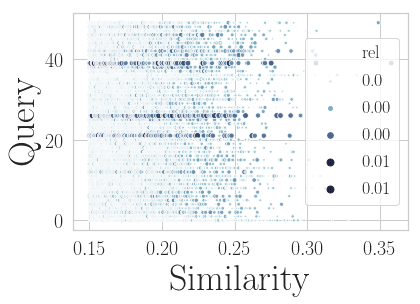

In [37]:
produce_distribution_plot(movielens_df, 0.15, 'uniform', 4000) 

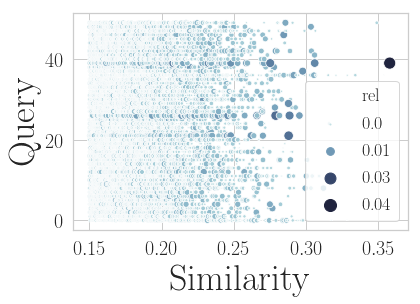

In [38]:
produce_distribution_plot(movielens_df, 0.15, 'standard', 4000) 

# Approximate Neighborhood is unfair?

Setup: Prepare a difficult dataset.

In [39]:
difficult_dataset, difficult_df, difficult_ground_truth = load_data('approximate', 'results_difficult.csv')

/usr/local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [40]:
difficult_df['p'] = difficult_df['prob'].apply(lambda x: 1/x)

In [41]:
dd = {}
for i, x in enumerate(difficult_df[['query_id', 'neighbor_id', 'p']].groupby(['query_id', 'neighbor_id']).count().reset_index()[['p']].values):
    dd[i] = x[0]
    

In [42]:
difficult_df['uncond_p'] = difficult_df[['neighbor_id', 'p']].apply(lambda x:x[1] * dd[x[0]] / 1000,axis=1)

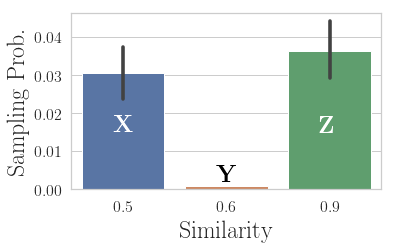

In [43]:
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['font.size'] = 24
ax = sns.barplot(data=difficult_df[difficult_df.neighbor_id >= 987].rename(columns={'similarity': 'Similarity', 'uncond_p' : 'Sampling Prob.'}), x='Similarity', y='Sampling Prob.')
ax.text(-0.1, 0.015, "$\mathbf{X}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(1.9, 0.015, "$\mathbf{Z}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(0.9, 0.002, "$\mathbf{Y}$", horizontalalignment='left', size='medium', color='black', weight='semibold')
#ax.set(yscale='log')
plt.tight_layout()
#plt.savefig('difficult-sampling.pdf')

Clear difference in sampling probabilities!